In [1]:
!pip install tensorflow_federated
!pip install attention

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.4/114.4 MB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.6/104.6 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 kB 10.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 558.5/558.5 kB 39.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.6/71.6 MB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 65.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.7/33.7 MB 36.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 255.8/255.8 kB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.9/238.9 kB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_federated as tff
from attention import Attention
import keras
import keras.backend as K
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
import collections
import random
import time
import math
import os

In [3]:
def create_fl_clients(data, target, no_of_clients):
    '''
    data - pandas dataframe
    clients - number of FL clients to split the data
    '''
    datasets = []
    for cid in range(no_of_clients):
        #creating a partition value as per the number of FL clients
        partition_size = math.floor(len(data) / no_of_clients)
        #creating indexes to subset the dataframe
        idx_from, idx_to = int(cid) * partition_size, (int(cid) + 1) * partition_size
        #subsetting dataframe
        train_batch = data[idx_from:idx_to]
        target_batch = target[idx_from:idx_to]

        dataset = tf.data.Dataset.from_tensor_slices((train_batch, target_batch)).batch(1)
        datasets.append(dataset)

    return datasets

In [4]:
def model_fn():
    model = create_model_fn()
    dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(2)
    input_spec = dataset.element_spec
    return tff.learning.models.from_keras_model(
      model,
      input_spec = input_spec,
      loss=tf.keras.losses.MeanAbsoluteError(),
      metrics=[tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsoluteError()])

In [5]:
import time
import datetime

now = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

def train(trainer, train_data, val_data, num_rounds, no_of_clients, fit_on):
    train_log_dir = "logs/past_" + str(past) + "_hours_" + str(SERVER_LR)

    train_summary_writer = tf.summary.create_file_writer(train_log_dir)
    #we want to set the federated learning params to be set to default
    state = trainer.initialize()
    #create model for evaluation
    eval = tff.learning.build_federated_evaluation(model_fn)
    return_state = None
    best_loss = None
    #for plotting we declare arrays
    train_acc = []
    train_mse = []
    train_loss = []
    eval_acc = []
    eval_mse = []
    eval_loss = []

    # test_acc = []
    # test_loss = []
    for n in range(num_rounds):
        t1 = time.time()
        print("Training...")
        #passing the new state with randomly chosen training dataset
        result = trainer.next(state, train_data)
        #setting new state for trained parameters
        state = result.state
        #declaring taining metrics
        train_metrics = result.metrics['client_work']['train']
        print("Evaluating...")
        #using learning algorithm we pass the currrent state of round for evaluation
        eval_metrics = eval(trainer.get_model_weights(state), [val_data])
        eval_metrics = eval_metrics['eval']
        print("Done...")
        t2 = time.time()
        print('Round:{a} Train - RMSE:{m:.4f} MAE:{x:.4f}, Loss:{t:.4f} | Eval - RMSE:{b:.4f} MAE:{d:.4f}, Loss:{c:.4f} | Time - {f:.2f}'.format(
              a=n+1,
              m=train_metrics['root_mean_squared_error'],
              x=train_metrics['mean_absolute_error'],
              t=train_metrics['loss'],
              b=eval_metrics['root_mean_squared_error'],
              d=eval_metrics['mean_absolute_error'],
              c=eval_metrics['loss'],
              # d=test_metrics['root_mean_squared_error'],
              # e=test_metrics['loss']
              f=t2-t1
        ))

        #early stopping
        if(best_loss != None and eval_metrics['loss'] >= best_loss):
          print("LOSS DID NOT IMPROVE...")
        else:
          print("Loss improved!")
          return_state = result.state
          best_loss = eval_metrics['loss']
          print("Saving model state...")

        #assigning metrics for plotting purposes
        train_acc.append(train_metrics['root_mean_squared_error'])
        train_mse.append(train_metrics['mean_absolute_error'])
        train_loss.append(train_metrics['loss'])

        eval_acc.append(eval_metrics['root_mean_squared_error'])
        eval_mse.append(eval_metrics['mean_absolute_error'])
        eval_loss.append(eval_metrics['loss'])

        with train_summary_writer.as_default():
          tf.summary.scalar("training/rmse", train_metrics['root_mean_squared_error'], step=n+1)
          tf.summary.scalar("training/mse", train_metrics['mean_absolute_error'], step=n+1)

          tf.summary.scalar("validation/rmse", eval_metrics['root_mean_squared_error'], step=n+1)
          tf.summary.scalar("validation/mse", eval_metrics['mean_absolute_error'], step=n+1)

        #using learning algorithm we pass the currrent state of round for testing
        # test_metrics = eval(trainer.get_model_weights(state), [test_client_data])
        # test_metrics = test_metrics['eval']




    return return_state, train_acc, train_mse, train_loss, eval_acc, eval_mse, eval_loss

In [6]:
import matplotlib
def plot(train_acc, train_mse, train_loss, eval_acc, eval_mse, eval_loss):
  plt.figure(figsize=(16, 6))
  plt.plot(train_acc, label="Training RMSE")
  plt.plot(eval_acc, label="Evaluation RMSE")
  plt.title("RMSE using past " + str(past) + " hours to predict next 1 hour (LR:" + str(SERVER_LR)+ ")")
  plt.xlabel("Rounds")
  plt.ylabel("RMSE")
  plt.legend()
  # plt.gca().xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True, nbins=len(train_acc)))
  plt.show()

  plt.figure(figsize=(16, 6))
  plt.plot(train_mse, label="Training MAE")
  plt.plot(eval_mse, label="Evaluation MAE")
  plt.title("MAE using past " + str(past) + " hours to predict next 1 hour (LR:" + str(SERVER_LR)+ ")")
  plt.xlabel("Rounds")
  plt.ylabel("MAE")
  plt.legend()
  # plt.gca().xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True, nbins=len(train_acc)))
  plt.show()

In [7]:
def normalize(data, train_split):
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    return (data - data_mean) / data_std
    # scaler = MinMaxScaler(feature_range=(0,1))
    # transformed = scaler.fit_transform(data)
    # return transformed, scaler

In [8]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

In [9]:
def create_model_fn():
  input = keras.layers.Input(shape=(past, input_size))
  layer = keras.layers.Conv1D(filters=15, kernel_size=2, padding="same", activation="relu")(input)
  layer = tf.keras.layers.MaxPooling1D(pool_size=2)(layer)
  layer = keras.layers.Conv1D(filters=12, kernel_size=2, padding="same", activation="relu")(layer)
  layer = tf.keras.layers.LSTM(32, return_sequences=True)(layer)
  layer = Attention(units=10)(layer)
  output = keras.layers.Dense(future)(layer)

  model = keras.Model(inputs=input, outputs=output)
  return model

In [10]:
s1 = pd.read_csv('final_s1.csv')
#dropping uncessary columns
s1 = s1.drop(['Unnamed: 0'], axis=1)

s2 = pd.read_csv('final_s2.csv')
#dropping uncessary columns
s2 = s2.drop(['Unnamed: 0'], axis=1)

In [11]:
def make_dataset(data, past, split_fraction=0.80):
  train_split = int(split_fraction * int(data.shape[0]))
  step = 1

  features = data[["temp", "wetb", "dewpt", "vappr", "pm10"]]
  features.index = data["datetime"]
  feature_columns = features.columns
  #print(features.head())

  targets = data[["pm2.5"]]
  targets_columns = targets.columns

  features = normalize(features.values, train_split)
  #targets = scaler.transform(targets.values)

  features_df = pd.DataFrame(features, columns = feature_columns)
  #targets = pd.DataFrame(targets, columns = targets_columns)

  input_size = len(features_df.columns)

  x_train, y_train = multivariate_data(features_df.values, targets["pm2.5"].values, 0,
                                                    train_split, past,
                                                    future, step)
  x_val, y_val = multivariate_data(features_df.values, targets["pm2.5"].values,
                                                train_split, None, past,
                                                future, step)
  return x_train, y_train, x_val, y_val

In [12]:
#setting number of clients
NUM_CLIENTS = 2
NUM_FIT = 5
ROUNDS = 100
future = 1
input_size = 5

In [13]:
def optimizers(SERVER_LR, CLIENT_LR):
  server_optimizer_fn=lambda: tf.keras.optimizers.SGD(SERVER_LR, momentum=0.9)
  client_optimizer_fn=lambda: tf.keras.optimizers.SGD(CLIENT_LR, momentum=0.9)

  return server_optimizer_fn, client_optimizer_fn

## Past 2

In [14]:
past = 2
x_train, y_train, x_val, y_val = make_dataset(s1, past, split_fraction=0.80)
s1_train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(1)
val_data = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(1)

x_train, y_train, x_val, y_val = make_dataset(s1, past, split_fraction=1.0)
s2_train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(1)

train_data = [s1_train_data, s2_train_data]

In [15]:
SERVER_LR = 0.0001
CLIENT_LR = 0.1

server_optimizer_fn, client_optimizer_fn = optimizers(SERVER_LR, CLIENT_LR)

trainer = tff.learning.algorithms.build_weighted_fed_avg(
        model_fn,
        server_optimizer_fn,
        client_optimizer_fn,
    )

state2, train_acc2, train_mse2, train_loss2, eval_acc2, eval_mse2, eval_loss2 = train(
    trainer,
    train_data,
    val_data,
    num_rounds=ROUNDS,
    no_of_clients=NUM_CLIENTS,
    fit_on=NUM_FIT
)

<ipython-input-5-caa6a9de1554>:13: DeprecationWarning: `tff.learning.build_federated_evaluation` is deprecated, use `tff.learning.algorithms.build_fed_eval` instead.
  eval = tff.learning.build_federated_evaluation(model_fn)


Training...
Evaluating...
Done...
Round:1 Train - RMSE:8.1750 MAE:4.6249, Loss:4.6249 | Eval - RMSE:5.3930 MAE:3.7780, Loss:3.7780 | Time - 48.24
Loss improved!
Saving model state...
Training...
Evaluating...
Done...
Round:2 Train - RMSE:7.7885 MAE:4.1455, Loss:4.1455 | Eval - RMSE:5.0871 MAE:3.4782, Loss:3.4782 | Time - 35.74
Loss improved!
Saving model state...
Training...
Evaluating...
Done...
Round:3 Train - RMSE:7.0326 MAE:3.4961, Loss:3.4961 | Eval - RMSE:4.5591 MAE:3.0691, Loss:3.0691 | Time - 32.78
Loss improved!
Saving model state...
Training...
Evaluating...
Done...
Round:4 Train - RMSE:6.2925 MAE:3.0081, Loss:3.0081 | Eval - RMSE:3.6891 MAE:2.4409, Loss:2.4409 | Time - 36.84
Loss improved!
Saving model state...
Training...
Evaluating...
Done...
Round:5 Train - RMSE:5.7944 MAE:2.7372, Loss:2.7372 | Eval - RMSE:2.6217 MAE:1.6418, Loss:1.6418 | Time - 34.26
Loss improved!
Saving model state...
Training...
Evaluating...
Done...
Round:6 Train - RMSE:5.4683 MAE:2.5864, Loss:2.5864

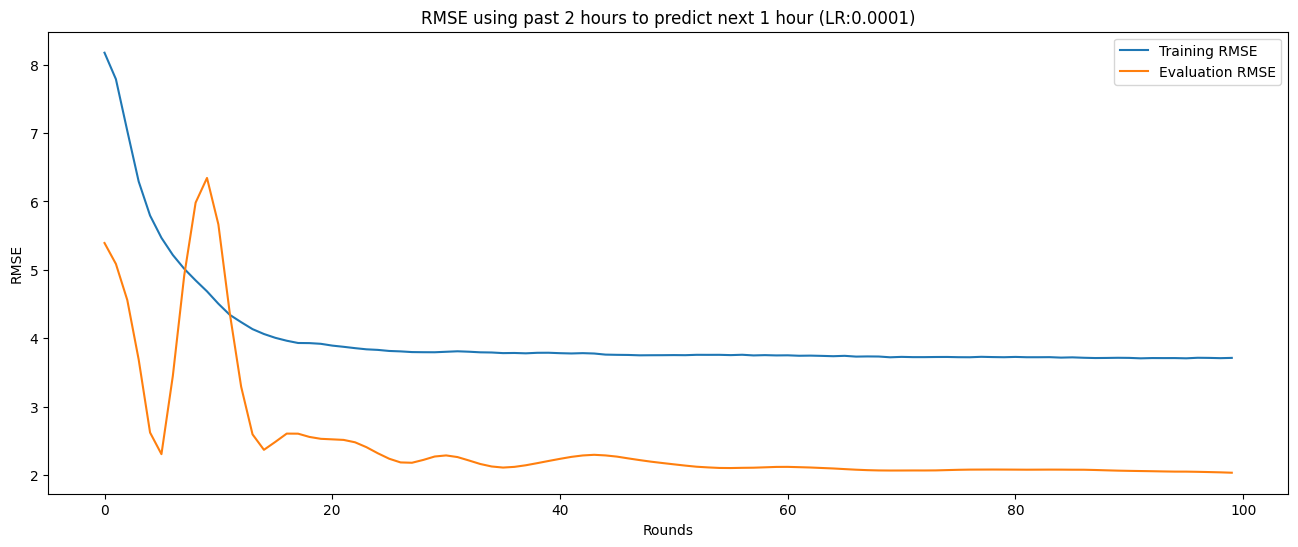

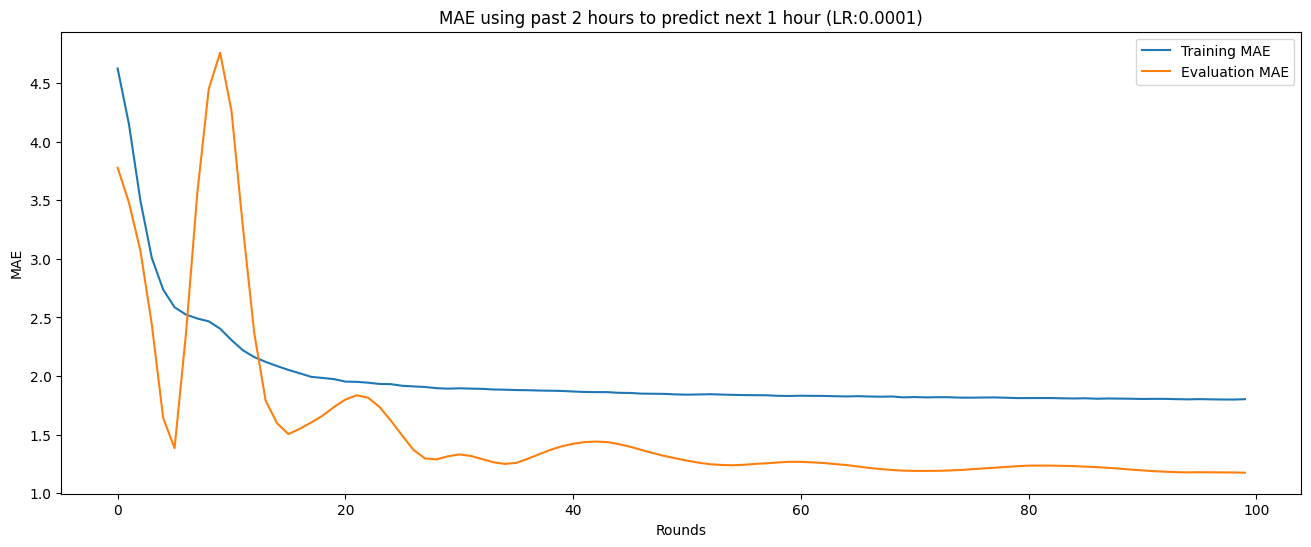

In [16]:
plot(train_acc2, train_mse2, train_loss2, eval_acc2, eval_mse2, eval_loss2)

In [17]:
test_log_dir = "logs/past_" + str(past) + "_hours_" + str(SERVER_LR) + "_test"
test_summary_writer = tf.summary.create_file_writer(test_log_dir)

model_test2 = create_model_fn()
trained_model = trainer.get_model_weights(state2)
trained_model.assign_weights_to(model_test2)
model_test2.save_weights('./checkpoints/private_data/past_2h')
# # plot_preds(model_test2, val_set)

predictions = []
true_val = []
index = 0
for x, y in val_data.skip(100).take(100):
  [pred] = model_test2.predict(x)[0]
  [true] = y[0].numpy()
  with test_summary_writer.as_default():
    tf.summary.scalar("predictions/true" ,true, step=index+1)
    tf.summary.scalar("predictions/predicted" ,pred, step=index+1)
  index += 1

  predictions.append(pred)
  true_val.append(true)

1/1 [==============================] - 0s 39ms/step


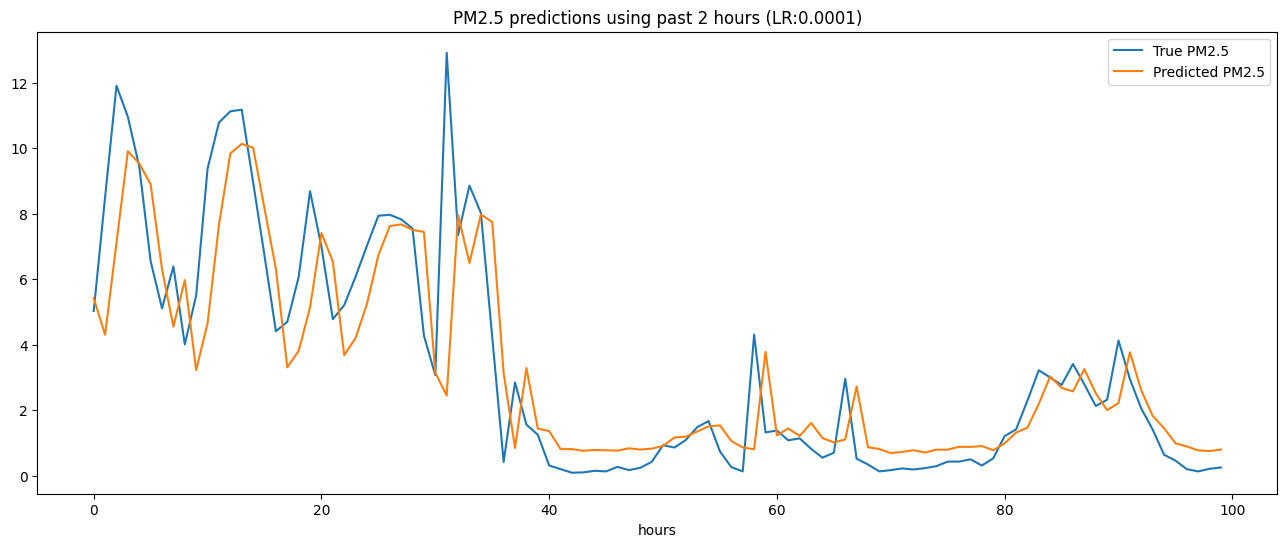

In [18]:
plt.figure(figsize=(16, 6))
plt.plot(true_val, label="True PM2.5")
plt.plot(predictions, label="Predicted PM2.5")
plt.title("PM2.5 predictions using past " + str(past) +" hours (LR:" + str(SERVER_LR)+ ")")
plt.xlabel("hours")
plt.legend()
plt.show()

In [19]:
pd.DataFrame({
    "Train Clients": [NUM_FIT],
    "Epochs": [ROUNDS],
    "Server LR": ["0.0001"],
    "Client LR": [0.1],
    "Validation RMSE": [min(eval_acc2)],
    "Validation MAE": [min(eval_mse2)]
})

,Train Clients,Epochs,Server LR,Client LR,Validation RMSE,Validation MAE
0,5,100,0.0001,0.1,2.034299,1.174135


## Past 4

In [20]:
past = 4
x_train, y_train, x_val, y_val = make_dataset(s1, past, split_fraction=0.80)
s1_train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(1)
val_data = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(1)

x_train, y_train, x_val, y_val = make_dataset(s1, past, split_fraction=1.0)
s2_train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(1)

train_data = [s1_train_data, s2_train_data]

In [21]:
SERVER_LR = 0.0001
CLIENT_LR = 0.1

server_optimizer_fn, client_optimizer_fn = optimizers(SERVER_LR, CLIENT_LR)

trainer = tff.learning.algorithms.build_weighted_fed_avg(
        model_fn,
        server_optimizer_fn,
        client_optimizer_fn,
    )

state2, train_acc2, train_mse2, train_loss2, eval_acc2, eval_mse2, eval_loss2 = train(
    trainer,
    train_data,
    val_data,
    num_rounds=ROUNDS,
    no_of_clients=NUM_CLIENTS,
    fit_on=NUM_FIT
)

<ipython-input-5-caa6a9de1554>:13: DeprecationWarning: `tff.learning.build_federated_evaluation` is deprecated, use `tff.learning.algorithms.build_fed_eval` instead.
  eval = tff.learning.build_federated_evaluation(model_fn)


Training...
Evaluating...
Done...
Round:1 Train - RMSE:7.6078 MAE:4.0883, Loss:4.0883 | Eval - RMSE:5.5209 MAE:3.9409, Loss:3.9409 | Time - 44.04
Loss improved!
Saving model state...
Training...
Evaluating...
Done...
Round:2 Train - RMSE:7.2616 MAE:3.7897, Loss:3.7897 | Eval - RMSE:5.2372 MAE:3.6384, Loss:3.6384 | Time - 42.15
Loss improved!
Saving model state...
Training...
Evaluating...
Done...
Round:3 Train - RMSE:6.7455 MAE:3.3415, Loss:3.3415 | Eval - RMSE:4.7436 MAE:3.2382, Loss:3.2382 | Time - 45.16
Loss improved!
Saving model state...
Training...
Evaluating...
Done...
Round:4 Train - RMSE:6.1817 MAE:3.0125, Loss:3.0125 | Eval - RMSE:3.8917 MAE:2.6170, Loss:2.6170 | Time - 42.81
Loss improved!
Saving model state...
Training...
Evaluating...
Done...
Round:5 Train - RMSE:5.8044 MAE:2.8177, Loss:2.8177 | Eval - RMSE:2.6303 MAE:1.6545, Loss:1.6545 | Time - 38.48
Loss improved!
Saving model state...
Training...
Evaluating...
Done...
Round:6 Train - RMSE:5.5093 MAE:2.6921, Loss:2.6921

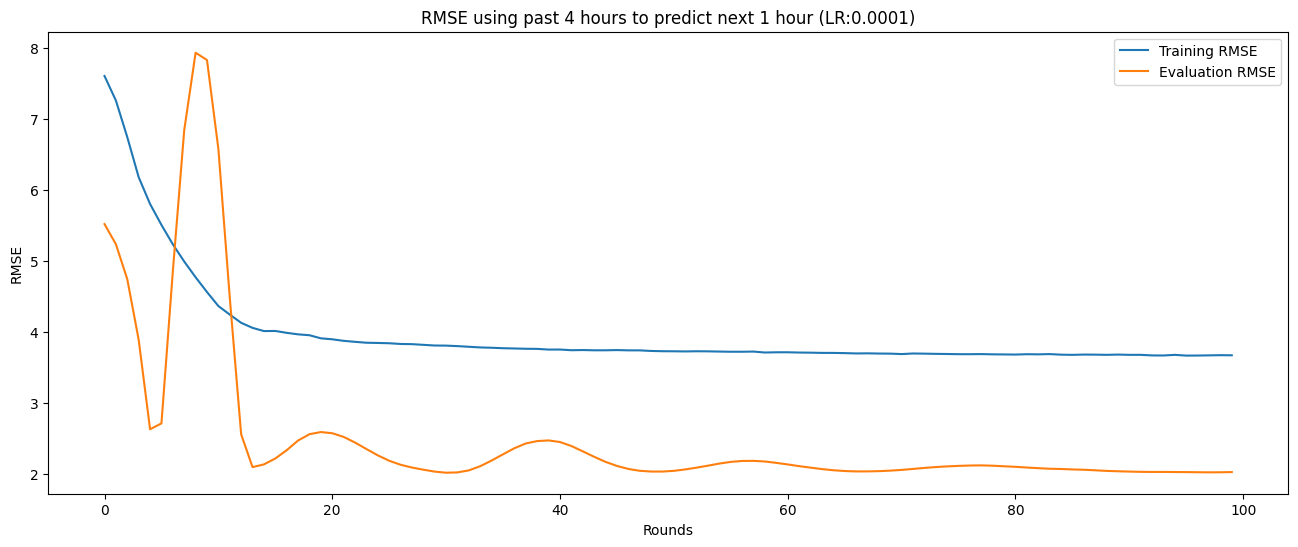

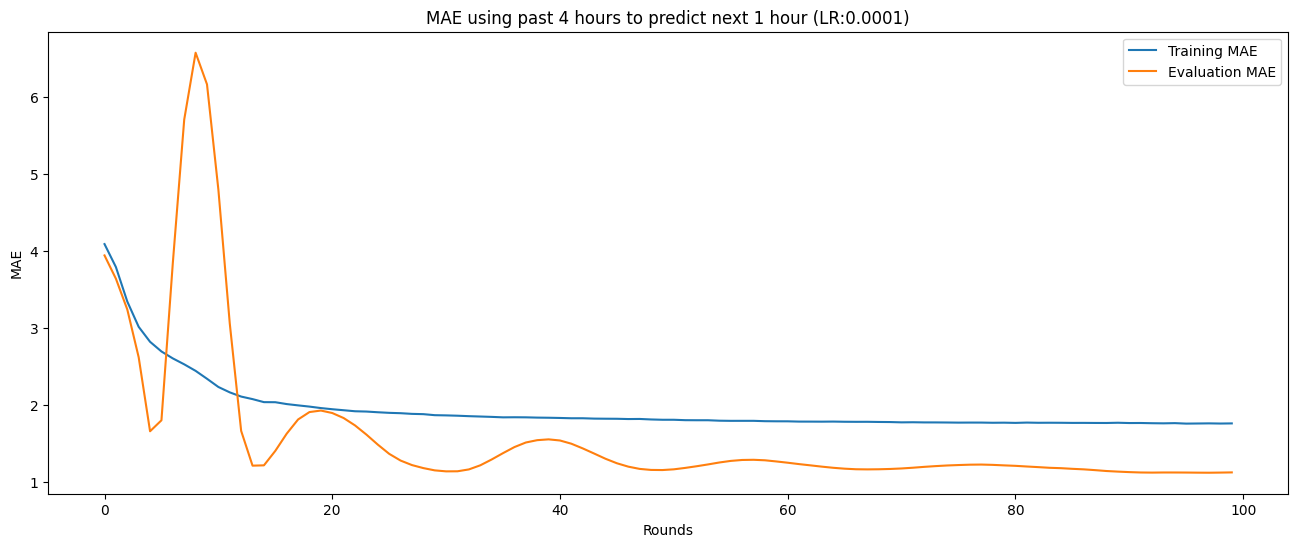

In [22]:
plot(train_acc2, train_mse2, train_loss2, eval_acc2, eval_mse2, eval_loss2)

In [23]:
test_log_dir = "logs/past_" + str(past) + "_hours_" + str(SERVER_LR) + "_test"
test_summary_writer = tf.summary.create_file_writer(test_log_dir)

model_test2 = create_model_fn()
trained_model = trainer.get_model_weights(state2)
trained_model.assign_weights_to(model_test2)
model_test2.save_weights('./checkpoints/private_data/past_4h')
# # plot_preds(model_test2, val_set)

predictions = []
true_val = []
index = 0
for x, y in val_data.skip(100).take(100):
  [pred] = model_test2.predict(x)[0]
  [true] = y[0].numpy()
  with test_summary_writer.as_default():
    tf.summary.scalar("predictions/true" ,true, step=index+1)
    tf.summary.scalar("predictions/predicted" ,pred, step=index+1)
  index += 1

  predictions.append(pred)
  true_val.append(true)

1/1 [==============================] - 0s 35ms/step


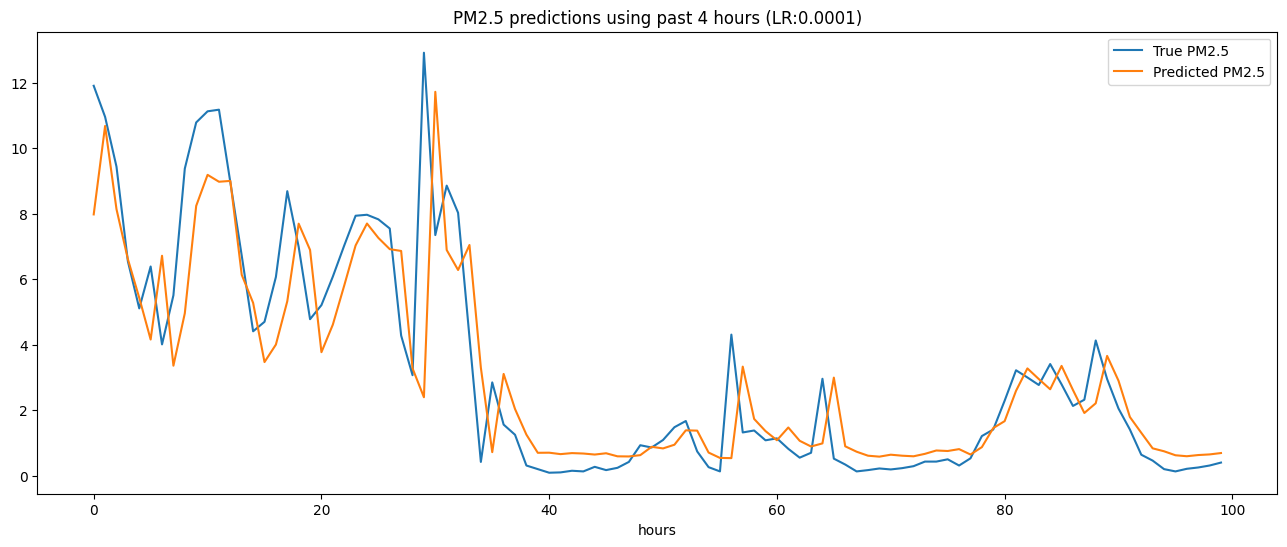

In [24]:
plt.figure(figsize=(16, 6))
plt.plot(true_val, label="True PM2.5")
plt.plot(predictions, label="Predicted PM2.5")
plt.title("PM2.5 predictions using past " + str(past) +" hours (LR:" + str(SERVER_LR)+ ")")
plt.xlabel("hours")
plt.legend()
plt.show()

In [25]:
pd.DataFrame({
    "Train Clients": [NUM_FIT],
    "Epochs": [ROUNDS],
    "Server LR": ["0.0001"],
    "Client LR": [0.1],
    "Validation RMSE": [min(eval_acc2)],
    "Validation MAE": [min(eval_mse2)]
})

,Train Clients,Epochs,Server LR,Client LR,Validation RMSE,Validation MAE
0,5,100,0.0001,0.1,2.017592,1.115488


# Past 6

In [26]:
past = 6
x_train, y_train, x_val, y_val = make_dataset(s1, past, split_fraction=0.80)
s1_train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(1)
val_data = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(1)

x_train, y_train, x_val, y_val = make_dataset(s1, past, split_fraction=1.0)
s2_train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(1)

train_data = [s1_train_data, s2_train_data]

In [27]:
SERVER_LR = 0.0001
CLIENT_LR = 0.1

server_optimizer_fn, client_optimizer_fn = optimizers(SERVER_LR, CLIENT_LR)

trainer = tff.learning.algorithms.build_weighted_fed_avg(
        model_fn,
        server_optimizer_fn,
        client_optimizer_fn,
    )

state2, train_acc2, train_mse2, train_loss2, eval_acc2, eval_mse2, eval_loss2 = train(
    trainer,
    train_data,
    val_data,
    num_rounds=ROUNDS,
    no_of_clients=NUM_CLIENTS,
    fit_on=NUM_FIT
)

<ipython-input-5-caa6a9de1554>:13: DeprecationWarning: `tff.learning.build_federated_evaluation` is deprecated, use `tff.learning.algorithms.build_fed_eval` instead.
  eval = tff.learning.build_federated_evaluation(model_fn)


Training...
Evaluating...
Done...
Round:1 Train - RMSE:7.5803 MAE:4.0374, Loss:4.0374 | Eval - RMSE:5.4318 MAE:3.8261, Loss:3.8261 | Time - 49.28
Loss improved!
Saving model state...
Training...
Evaluating...
Done...
Round:2 Train - RMSE:7.3941 MAE:3.8990, Loss:3.8990 | Eval - RMSE:5.0820 MAE:3.4761, Loss:3.4761 | Time - 44.69
Loss improved!
Saving model state...
Training...
Evaluating...
Done...
Round:3 Train - RMSE:6.9830 MAE:3.5509, Loss:3.5509 | Eval - RMSE:4.4545 MAE:2.9694, Loss:2.9694 | Time - 46.74
Loss improved!
Saving model state...
Training...
Evaluating...
Done...
Round:4 Train - RMSE:6.4707 MAE:3.2165, Loss:3.2165 | Eval - RMSE:3.5782 MAE:2.3252, Loss:2.3252 | Time - 47.01
Loss improved!
Saving model state...
Training...
Evaluating...
Done...
Round:5 Train - RMSE:6.0800 MAE:3.0277, Loss:3.0277 | Eval - RMSE:2.7802 MAE:1.7465, Loss:1.7465 | Time - 48.15
Loss improved!
Saving model state...
Training...
Evaluating...
Done...
Round:6 Train - RMSE:5.7631 MAE:2.8965, Loss:2.8965

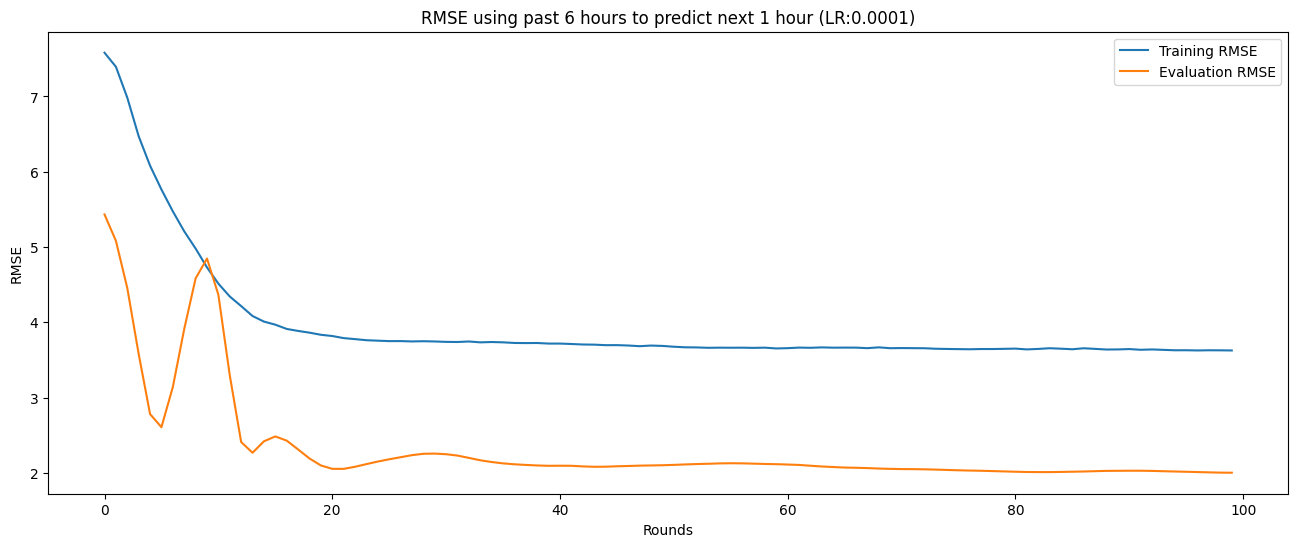

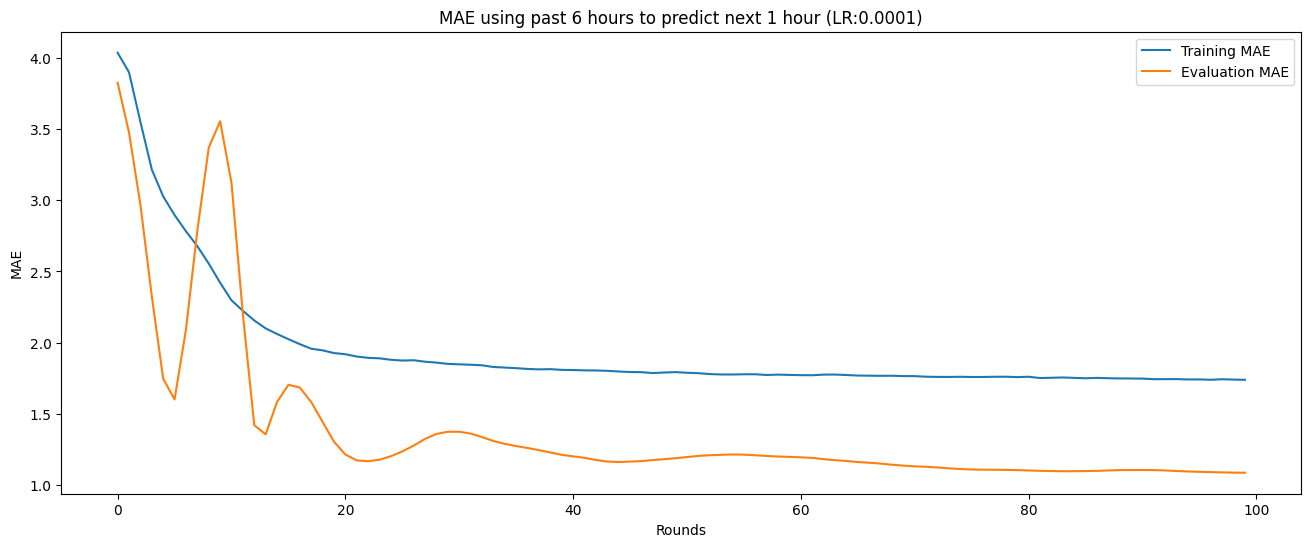

In [28]:
plot(train_acc2, train_mse2, train_loss2, eval_acc2, eval_mse2, eval_loss2)

In [29]:
test_log_dir = "logs/past_" + str(past) + "_hours_" + str(SERVER_LR) + "_test"
test_summary_writer = tf.summary.create_file_writer(test_log_dir)

model_test2 = create_model_fn()
trained_model = trainer.get_model_weights(state2)
trained_model.assign_weights_to(model_test2)
model_test2.save_weights('./checkpoints/private_data/past_6h')
# # plot_preds(model_test2, val_set)

predictions = []
true_val = []
index = 0
for x, y in val_data.skip(100).take(100):
  [pred] = model_test2.predict(x)[0]
  [true] = y[0].numpy()
  with test_summary_writer.as_default():
    tf.summary.scalar("predictions/true" ,true, step=index+1)
    tf.summary.scalar("predictions/predicted" ,pred, step=index+1)
  index += 1

  predictions.append(pred)
  true_val.append(true)

1/1 [==============================] - 0s 30ms/step


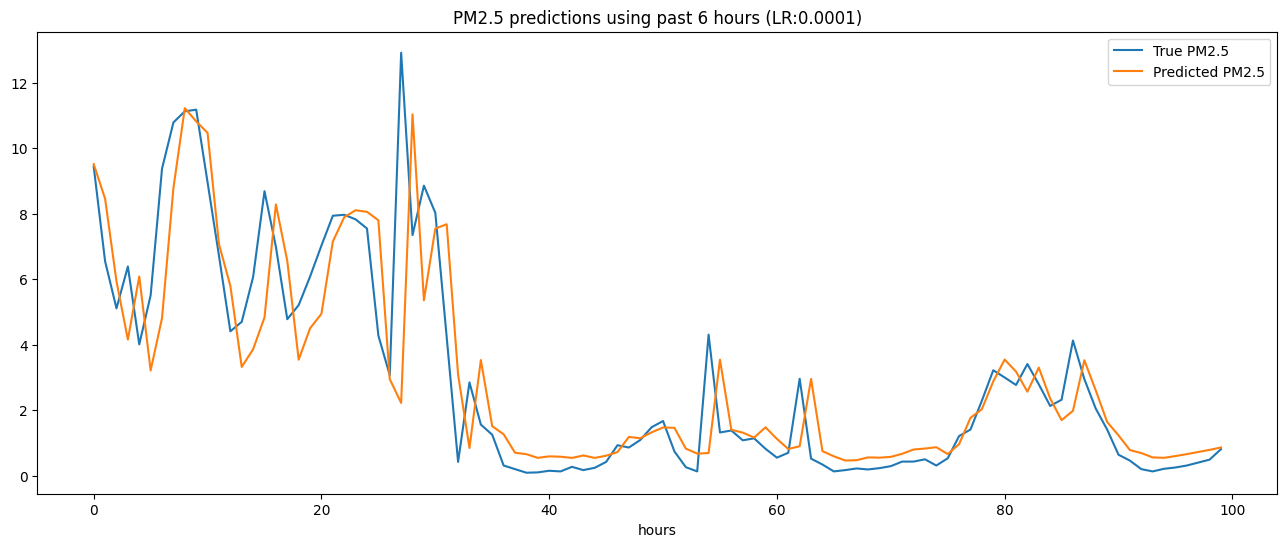

In [30]:
plt.figure(figsize=(16, 6))
plt.plot(true_val, label="True PM2.5")
plt.plot(predictions, label="Predicted PM2.5")
plt.title("PM2.5 predictions using past " + str(past) +" hours (LR:" + str(SERVER_LR)+ ")")
plt.xlabel("hours")
plt.legend()
plt.show()

In [31]:
pd.DataFrame({
    "Train Clients": [NUM_FIT],
    "Epochs": [ROUNDS],
    "Server LR": ["0.0001"],
    "Client LR": [0.1],
    "Validation RMSE": [min(eval_acc2)],
    "Validation MAE": [min(eval_mse2)]
})

,Train Clients,Epochs,Server LR,Client LR,Validation RMSE,Validation MAE
0,5,100,0.0001,0.1,2.001064,1.085417


# Past 8

In [32]:
past = 8
x_train, y_train, x_val, y_val = make_dataset(s1, past, split_fraction=0.80)
s1_train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(1)
val_data = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(1)

x_train, y_train, x_val, y_val = make_dataset(s1, past, split_fraction=1.0)
s2_train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(1)

train_data = [s1_train_data, s2_train_data]

In [33]:
SERVER_LR = 0.0001
CLIENT_LR = 0.1

server_optimizer_fn, client_optimizer_fn = optimizers(SERVER_LR, CLIENT_LR)

trainer = tff.learning.algorithms.build_weighted_fed_avg(
        model_fn,
        server_optimizer_fn,
        client_optimizer_fn,
    )

state2, train_acc2, train_mse2, train_loss2, eval_acc2, eval_mse2, eval_loss2 = train(
    trainer,
    train_data,
    val_data,
    num_rounds=ROUNDS,
    no_of_clients=NUM_CLIENTS,
    fit_on=NUM_FIT
)

<ipython-input-5-caa6a9de1554>:13: DeprecationWarning: `tff.learning.build_federated_evaluation` is deprecated, use `tff.learning.algorithms.build_fed_eval` instead.
  eval = tff.learning.build_federated_evaluation(model_fn)


Training...
Evaluating...
Done...
Round:1 Train - RMSE:7.3945 MAE:3.9407, Loss:3.9407 | Eval - RMSE:5.6235 MAE:4.0811, Loss:4.0811 | Time - 56.22
Loss improved!
Saving model state...
Training...
Evaluating...
Done...
Round:2 Train - RMSE:7.2492 MAE:3.8329, Loss:3.8329 | Eval - RMSE:5.3744 MAE:3.8099, Loss:3.8099 | Time - 58.48
Loss improved!
Saving model state...
Training...
Evaluating...
Done...
Round:3 Train - RMSE:6.9153 MAE:3.5477, Loss:3.5477 | Eval - RMSE:4.8916 MAE:3.3795, Loss:3.3795 | Time - 54.05
Loss improved!
Saving model state...
Training...
Evaluating...
Done...
Round:4 Train - RMSE:6.4854 MAE:3.2631, Loss:3.2631 | Eval - RMSE:4.0889 MAE:2.7524, Loss:2.7524 | Time - 53.85
Loss improved!
Saving model state...
Training...
Evaluating...
Done...
Round:5 Train - RMSE:6.1068 MAE:3.0587, Loss:3.0587 | Eval - RMSE:3.0382 MAE:1.9459, Loss:1.9459 | Time - 54.55
Loss improved!
Saving model state...
Training...
Evaluating...
Done...
Round:6 Train - RMSE:5.7581 MAE:2.8652, Loss:2.8652

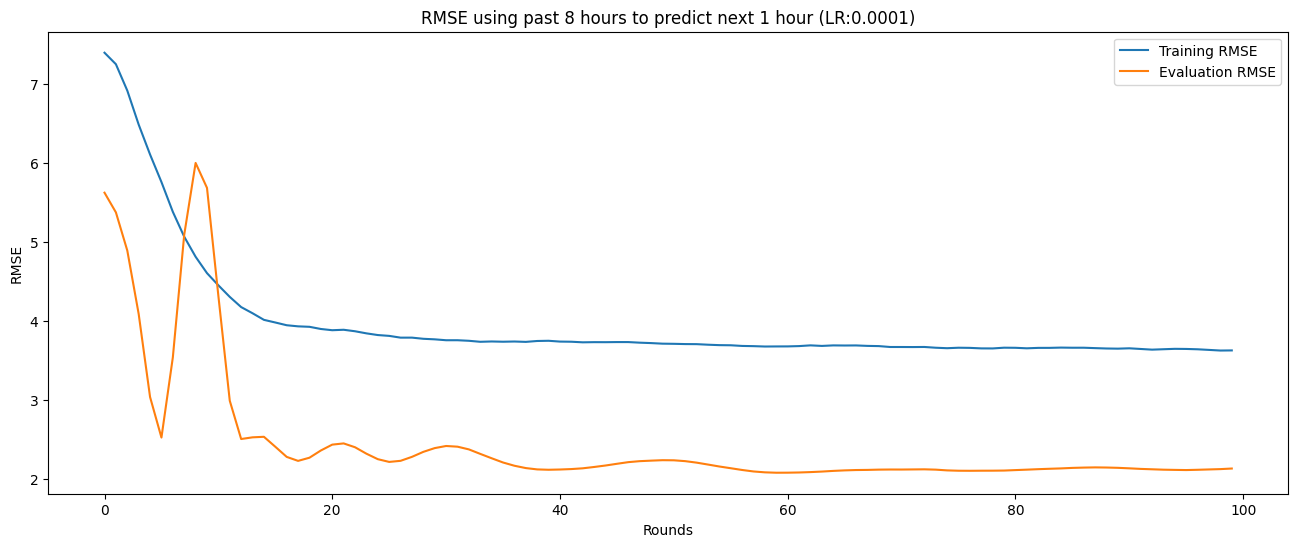

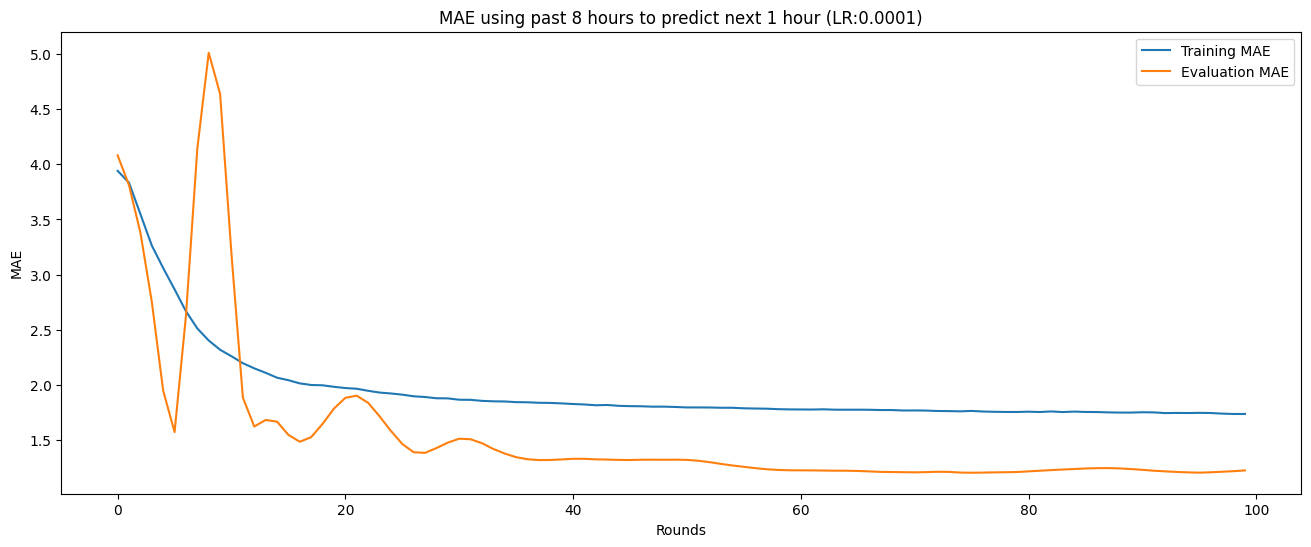

In [34]:
plot(train_acc2, train_mse2, train_loss2, eval_acc2, eval_mse2, eval_loss2)

In [35]:
test_log_dir = "logs/past_" + str(past) + "_hours_" + str(SERVER_LR) + "_test"
test_summary_writer = tf.summary.create_file_writer(test_log_dir)

model_test2 = create_model_fn()
trained_model = trainer.get_model_weights(state2)
trained_model.assign_weights_to(model_test2)
model_test2.save_weights('./checkpoints/private_data/past_8h')
# # plot_preds(model_test2, val_set)

predictions = []
true_val = []
index = 0
for x, y in val_data.skip(100).take(100):
  [pred] = model_test2.predict(x)[0]
  [true] = y[0].numpy()
  with test_summary_writer.as_default():
    tf.summary.scalar("predictions/true" ,true, step=index+1)
    tf.summary.scalar("predictions/predicted" ,pred, step=index+1)
  index += 1

  predictions.append(pred)
  true_val.append(true)

1/1 [==============================] - 0s 28ms/step


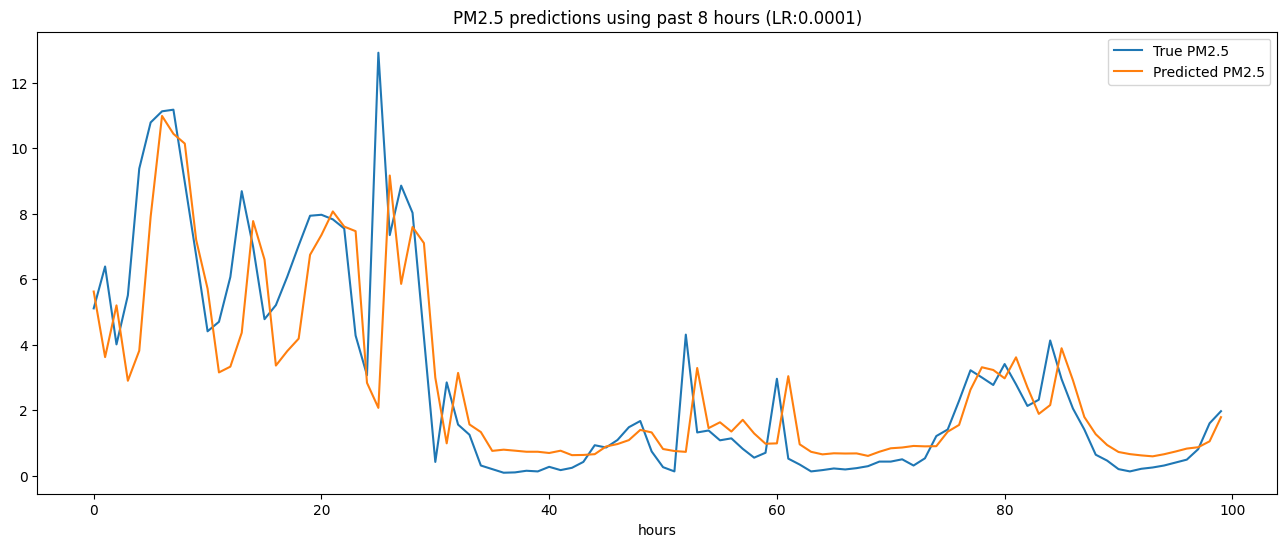

In [36]:
plt.figure(figsize=(16, 6))
plt.plot(true_val, label="True PM2.5")
plt.plot(predictions, label="Predicted PM2.5")
plt.title("PM2.5 predictions using past " + str(past) +" hours (LR:" + str(SERVER_LR)+ ")")
plt.xlabel("hours")
plt.legend()
plt.show()

In [37]:
pd.DataFrame({
    "Train Clients": [NUM_FIT],
    "Epochs": [ROUNDS],
    "Server LR": ["0.0001"],
    "Client LR": [0.1],
    "Validation RMSE": [min(eval_acc2)],
    "Validation MAE": [min(eval_mse2)]
})

,Train Clients,Epochs,Server LR,Client LR,Validation RMSE,Validation MAE
0,5,100,0.0001,0.1,2.080252,1.201086


# Past 10

In [38]:
past = 10
x_train, y_train, x_val, y_val = make_dataset(s1, past, split_fraction=0.80)
s1_train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(1)
val_data = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(1)

x_train, y_train, x_val, y_val = make_dataset(s1, past, split_fraction=1.0)
s2_train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(1)

train_data = [s1_train_data, s2_train_data]

In [39]:
SERVER_LR = 0.0001
CLIENT_LR = 0.1

server_optimizer_fn, client_optimizer_fn = optimizers(SERVER_LR, CLIENT_LR)

trainer = tff.learning.algorithms.build_weighted_fed_avg(
        model_fn,
        server_optimizer_fn,
        client_optimizer_fn,
    )

state2, train_acc2, train_mse2, train_loss2, eval_acc2, eval_mse2, eval_loss2 = train(
    trainer,
    train_data,
    val_data,
    num_rounds=ROUNDS,
    no_of_clients=NUM_CLIENTS,
    fit_on=NUM_FIT
)

<ipython-input-5-caa6a9de1554>:13: DeprecationWarning: `tff.learning.build_federated_evaluation` is deprecated, use `tff.learning.algorithms.build_fed_eval` instead.
  eval = tff.learning.build_federated_evaluation(model_fn)


Training...
Evaluating...
Done...
Round:1 Train - RMSE:7.4818 MAE:4.0594, Loss:4.0594 | Eval - RMSE:5.5509 MAE:3.9865, Loss:3.9865 | Time - 66.64
Loss improved!
Saving model state...
Training...
Evaluating...
Done...
Round:2 Train - RMSE:7.3223 MAE:3.9200, Loss:3.9200 | Eval - RMSE:5.2174 MAE:3.6196, Loss:3.6196 | Time - 60.46
Loss improved!
Saving model state...
Training...
Evaluating...
Done...
Round:3 Train - RMSE:7.0236 MAE:3.6713, Loss:3.6713 | Eval - RMSE:4.6316 MAE:3.1207, Loss:3.1207 | Time - 61.82
Loss improved!
Saving model state...
Training...
Evaluating...
Done...
Round:4 Train - RMSE:6.6483 MAE:3.3989, Loss:3.3989 | Eval - RMSE:3.8154 MAE:2.5177, Loss:2.5177 | Time - 59.68
Loss improved!
Saving model state...
Training...
Evaluating...
Done...
Round:5 Train - RMSE:6.3128 MAE:3.2071, Loss:3.2071 | Eval - RMSE:3.0070 MAE:1.9339, Loss:1.9339 | Time - 61.95
Loss improved!
Saving model state...
Training...
Evaluating...
Done...
Round:6 Train - RMSE:6.0038 MAE:3.0371, Loss:3.0371

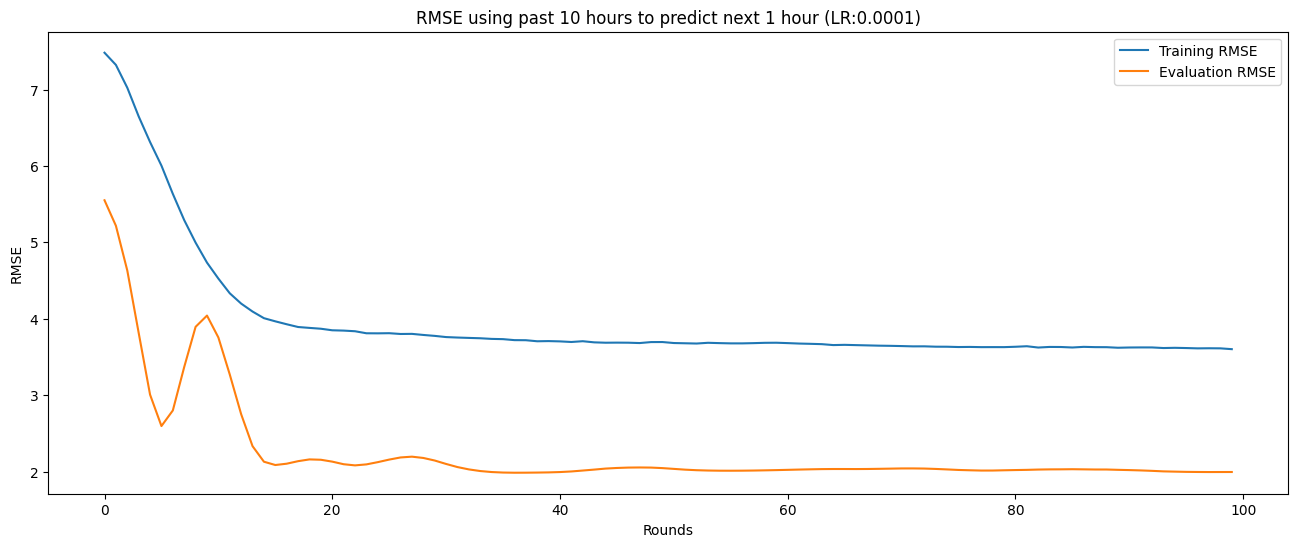

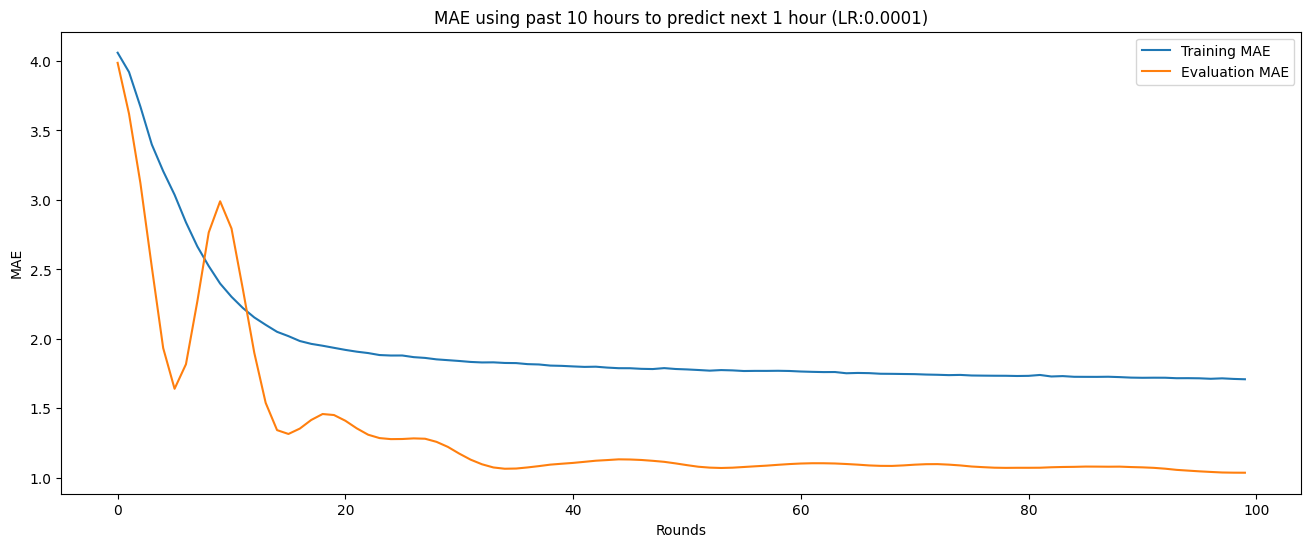

In [40]:
plot(train_acc2, train_mse2, train_loss2, eval_acc2, eval_mse2, eval_loss2)

In [41]:
test_log_dir = "logs/past_" + str(past) + "_hours_" + str(SERVER_LR) + "_test"
test_summary_writer = tf.summary.create_file_writer(test_log_dir)

model_test2 = create_model_fn()
trained_model = trainer.get_model_weights(state2)
trained_model.assign_weights_to(model_test2)
model_test2.save_weights('./checkpoints/private_data/past_10h')
# # plot_preds(model_test2, val_set)

predictions = []
true_val = []
index = 0
for x, y in val_data.skip(100).take(100):
  [pred] = model_test2.predict(x)[0]
  [true] = y[0].numpy()
  with test_summary_writer.as_default():
    tf.summary.scalar("predictions/true" ,true, step=index+1)
    tf.summary.scalar("predictions/predicted" ,pred, step=index+1)
  index += 1

  predictions.append(pred)
  true_val.append(true)

1/1 [==============================] - 0s 25ms/step


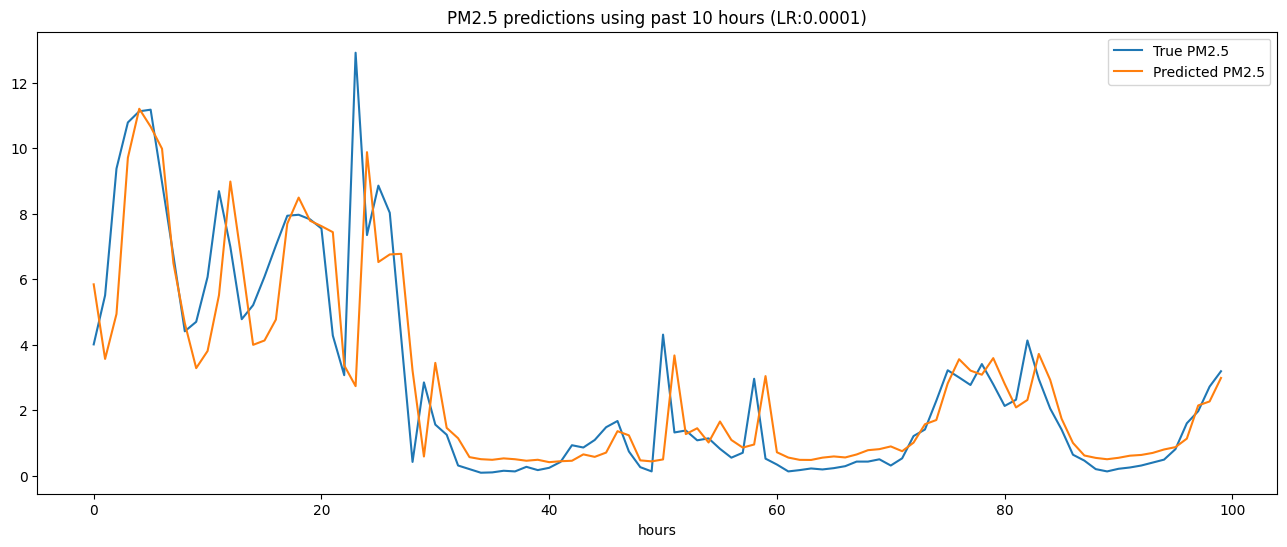

In [42]:
plt.figure(figsize=(16, 6))
plt.plot(true_val, label="True PM2.5")
plt.plot(predictions, label="Predicted PM2.5")
plt.title("PM2.5 predictions using past " + str(past) +" hours (LR:" + str(SERVER_LR)+ ")")
plt.xlabel("hours")
plt.legend()
plt.show()

In [43]:
pd.DataFrame({
    "Train Clients": [NUM_FIT],
    "Epochs": [ROUNDS],
    "Server LR": ["0.0001"],
    "Client LR": [0.1],
    "Validation RMSE": [min(eval_acc2)],
    "Validation MAE": [min(eval_mse2)]
})

,Train Clients,Epochs,Server LR,Client LR,Validation RMSE,Validation MAE
0,5,100,0.0001,0.1,1.985074,1.036834


# Past 12

In [44]:
past = 12
x_train, y_train, x_val, y_val = make_dataset(s1, past, split_fraction=0.80)
s1_train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(1)
val_data = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(1)

x_train, y_train, x_val, y_val = make_dataset(s1, past, split_fraction=1.0)
s2_train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(1)

train_data = [s1_train_data, s2_train_data]

In [45]:
SERVER_LR = 0.0001
CLIENT_LR = 0.1

server_optimizer_fn, client_optimizer_fn = optimizers(SERVER_LR, CLIENT_LR)

trainer = tff.learning.algorithms.build_weighted_fed_avg(
        model_fn,
        server_optimizer_fn,
        client_optimizer_fn,
    )

state2, train_acc2, train_mse2, train_loss2, eval_acc2, eval_mse2, eval_loss2 = train(
    trainer,
    train_data,
    val_data,
    num_rounds=ROUNDS,
    no_of_clients=NUM_CLIENTS,
    fit_on=NUM_FIT
)

<ipython-input-5-caa6a9de1554>:13: DeprecationWarning: `tff.learning.build_federated_evaluation` is deprecated, use `tff.learning.algorithms.build_fed_eval` instead.
  eval = tff.learning.build_federated_evaluation(model_fn)


Training...
Evaluating...
Done...
Round:1 Train - RMSE:7.3920 MAE:4.0334, Loss:4.0334 | Eval - RMSE:5.4040 MAE:3.7848, Loss:3.7848 | Time - 72.58
Loss improved!
Saving model state...
Training...
Evaluating...
Done...
Round:2 Train - RMSE:7.2464 MAE:3.8820, Loss:3.8820 | Eval - RMSE:5.1438 MAE:3.5304, Loss:3.5304 | Time - 69.82
Loss improved!
Saving model state...
Training...
Evaluating...
Done...
Round:3 Train - RMSE:6.9747 MAE:3.6381, Loss:3.6381 | Eval - RMSE:4.7215 MAE:3.1996, Loss:3.1996 | Time - 68.70
Loss improved!
Saving model state...
Training...
Evaluating...
Done...
Round:4 Train - RMSE:6.6044 MAE:3.3751, Loss:3.3751 | Eval - RMSE:4.0861 MAE:2.7531, Loss:2.7531 | Time - 84.63
Loss improved!
Saving model state...
Training...
Evaluating...
Done...
Round:5 Train - RMSE:6.2149 MAE:3.1162, Loss:3.1162 | Eval - RMSE:3.2960 MAE:2.1628, Loss:2.1628 | Time - 68.11
Loss improved!
Saving model state...
Training...
Evaluating...
Done...
Round:6 Train - RMSE:5.8243 MAE:2.8897, Loss:2.8897

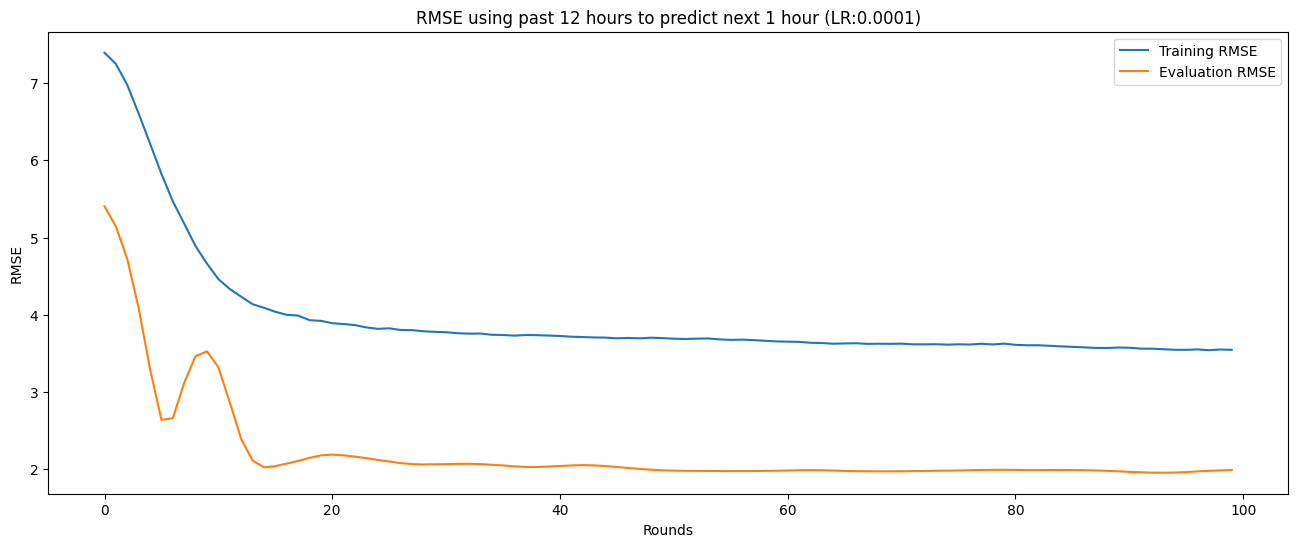

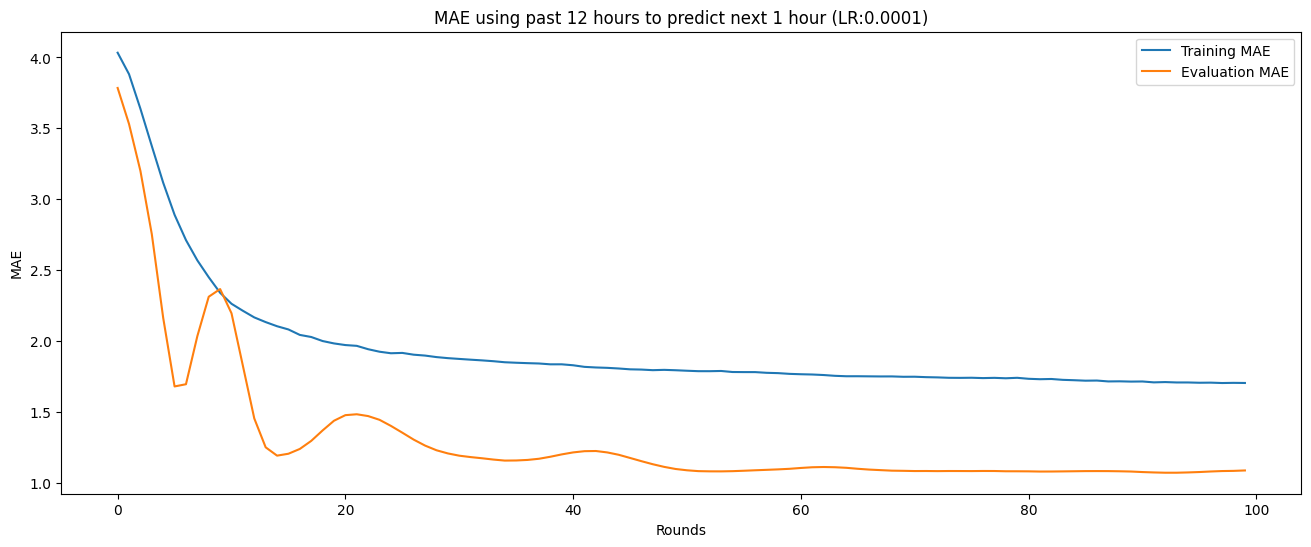

In [46]:
plot(train_acc2, train_mse2, train_loss2, eval_acc2, eval_mse2, eval_loss2)

In [47]:
test_log_dir = "logs/past_" + str(past) + "_hours_" + str(SERVER_LR) + "_test"
test_summary_writer = tf.summary.create_file_writer(test_log_dir)

model_test2 = create_model_fn()
trained_model = trainer.get_model_weights(state2)
trained_model.assign_weights_to(model_test2)
model_test2.save_weights('./checkpoints/private_data/past_12h')
# # plot_preds(model_test2, val_set)

predictions = []
true_val = []
index = 0
for x, y in val_data.skip(100).take(100):
  [pred] = model_test2.predict(x)[0]
  [true] = y[0].numpy()
  with test_summary_writer.as_default():
    tf.summary.scalar("predictions/true" ,true, step=index+1)
    tf.summary.scalar("predictions/predicted" ,pred, step=index+1)
  index += 1

  predictions.append(pred)
  true_val.append(true)

1/1 [==============================] - 0s 38ms/step


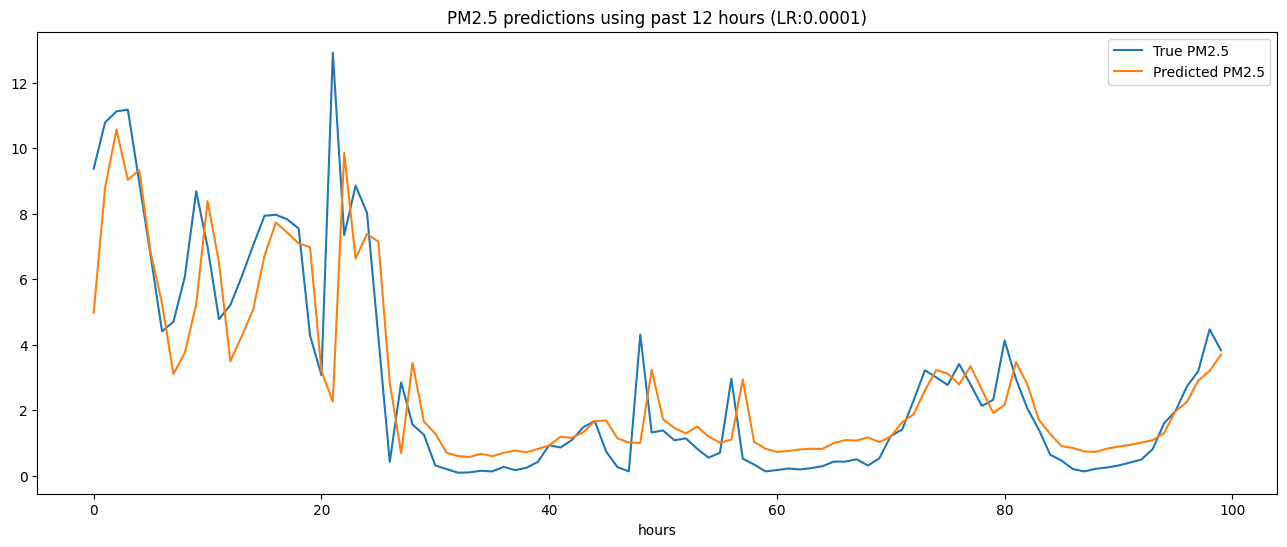

In [48]:
plt.figure(figsize=(16, 6))
plt.plot(true_val, label="True PM2.5")
plt.plot(predictions, label="Predicted PM2.5")
plt.title("PM2.5 predictions using past " + str(past) +" hours (LR:" + str(SERVER_LR)+ ")")
plt.xlabel("hours")
plt.legend()
plt.show()

In [49]:
pd.DataFrame({
    "Train Clients": [NUM_FIT],
    "Epochs": [ROUNDS],
    "Server LR": ["0.0001"],
    "Client LR": [0.1],
    "Validation RMSE": [min(eval_acc2)],
    "Validation MAE": [min(eval_mse2)]
})

,Train Clients,Epochs,Server LR,Client LR,Validation RMSE,Validation MAE
0,5,100,0.0001,0.1,1.956625,1.069696
